In [1]:
import numpy as np
import keras
import scipy.io as sio
import pandas as pd
import tensorflow as tf
from sklearn import preprocessing
import matplotlib.pyplot as plt 
from keras import layers
from keras.models import Sequential
from livelossplot.keras import PlotLossesCallback

In [2]:
filename = 'MarmousiModel2.mat'
marmousi_cube = sio.loadmat(filename)

### Carregar dados e cubos de Sísmica e Impedância

In [3]:
VP = marmousi_cube['Vp']
#VS = marmousi_cube['Vs']
#IS = marmousi_cube['IS']
pimpedance = marmousi_cube['IP']
seismic = marmousi_cube['seismic']

WAVELET = marmousi_cube['wavelet']

### Parameters 

In [4]:
WELLS_LOC = np.arange(0,pimpedance.shape[1],40)
BATCH_SIZE = 5
# Size of the noise vector
noise_dim = 700
IMG_SHAPE = (700,1,1)


### Normalizar Sismica

In [5]:
def forward_seis(wavelet,impedance):
    refl = np.diff(impedance,axis=0)/(impedance[0:-1]+impedance[1:])
    if refl.ndim > 1:
        synth = np.convolve(refl[:,0], wavelet[:,0], mode='same')
    else:
        synth = np.convolve(refl, wavelet[:,0], mode='same')
    return synth

In [6]:
for i in range(0,pimpedance.shape[1]):
    seismic[:,i] = forward_seis(WAVELET,pimpedance[:,i])

In [7]:
seismic_norm = seismic.flatten()
ymin = 0
ymax = 1
seismic_norm = (ymax-ymin)*(seismic_norm-np.min(seismic_norm))/(np.max(seismic_norm)-np.min(seismic_norm)) + ymin
seismic_norm = seismic_norm.reshape(seismic.shape)
#seismic_norm = seismic

In [8]:
pimpedance_norm = pimpedance.flatten()
ymin = 0
ymax = 1
pimpedance_norm = (ymax-ymin)*(pimpedance_norm-np.min(pimpedance_norm))/(np.max(pimpedance_norm)-np.min(pimpedance_norm)) + ymin
pimpedance = pimpedance_norm.reshape(pimpedance.shape)
#seismic_norm = seismic

### Visualizar estatísticas

In [9]:
data_info = pd.DataFrame(zip(seismic_norm.flatten(),
                             pimpedance.flatten()),
                         columns=['Seismic CL Stats','PImp CL Stats'])
data_info.describe()

,Seismic CL Stats,PImp CL Stats
count,1.904700e+06,1.904700e+06
mean,4.857948e-01,3.337762e-01
std,4.330583e-02,2.723444e-01
min,0.000000e+00,0.000000e+00
25%,4.779977e-01,9.895911e-02
50%,4.857949e-01,2.469055e-01
75%,4.924746e-01,5.268558e-01
max,1.000000e+00,1.000000e+00


### Preparar os Dados

In [10]:
X_train = np.transpose(seismic_norm[:,WELLS_LOC[0:]])
Y_train = np.transpose(pimpedance[:-1,WELLS_LOC[0:]])
X_train = np.expand_dims(X_train,axis=2)
Y_train = np.expand_dims(Y_train,axis=2)

X_valid = np.transpose(seismic_norm[:,WELLS_LOC[80:]])
Y_valid = np.transpose(pimpedance[:-1,WELLS_LOC[80:]])
X_valid = np.expand_dims(X_valid,axis=2)
Y_valid = np.expand_dims(Y_valid,axis=2)

X_test = np.transpose(seismic_norm)
Y_test = np.transpose(pimpedance[:-1,:])
X_test = np.expand_dims(X_test,axis=2)
Y_test = np.expand_dims(Y_test,axis=2)


In [11]:
print('     IP (Y_train) shape: ',Y_train.shape)
print('seismic (X_train) shape: ',X_train.shape)

     IP (Y_train) shape:  (69, 700, 1)
seismic (X_train) shape:  (69, 700, 1)


### Visualizar Dados

Text(0.5, 1.0, 'Output P-Impedance Test - Ground True')

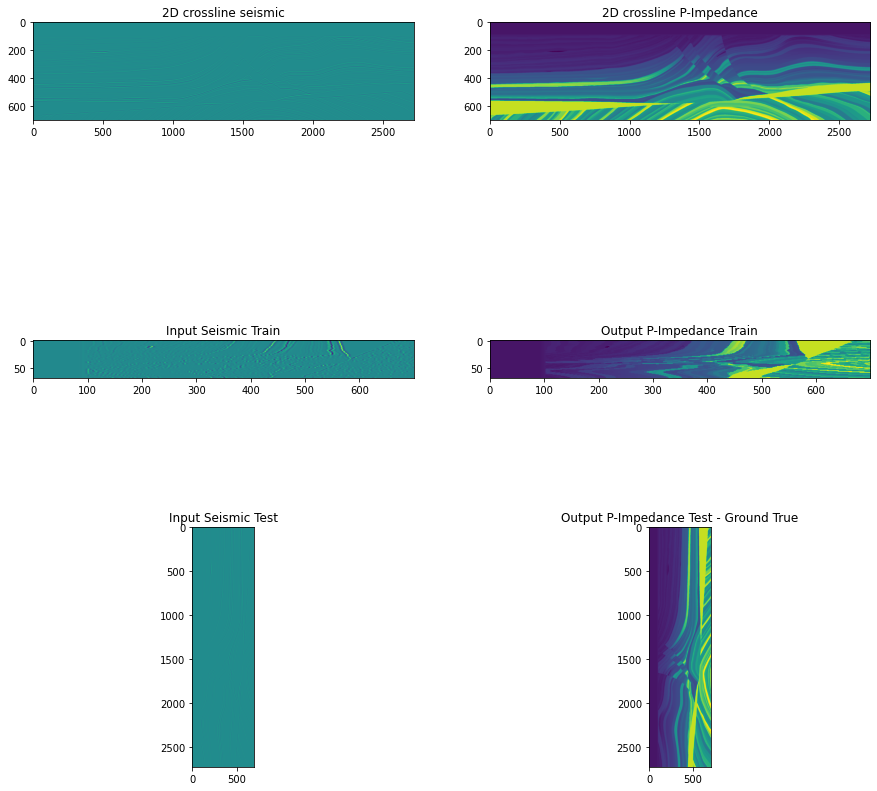

In [12]:
fig1, axes1 = plt.subplots(nrows=3, ncols=2, figsize=(15,15))


axes1[0,0].imshow(seismic)
axes1[0,0].set_title("2D crossline seismic")

axes1[0,1].imshow(pimpedance)
axes1[0,1].set_title("2D crossline P-Impedance")


axes1[1,0].imshow(X_train[:,:,0])
axes1[1,0].set_title("Input Seismic Train")

axes1[1,1].imshow(Y_train[:,:,0])
axes1[1,1].set_title("Output P-Impedance Train")

axes1[2,0].imshow(X_test[:,:,0])
axes1[2,0].set_title("Input Seismic Test")
axes1[2,1].imshow(Y_test[:,:,0])
axes1[2,1].set_title("Output P-Impedance Test - Ground True")

## Criação e Configuração da Rede

In [16]:
callback =  tf.keras.callbacks.EarlyStopping(monitor='loss', 
            mode='min',
            restore_best_weights=True, 
            verbose=2, 
            patience=300)

In [17]:
numFeatures = 1
numHiddenUnits1 = 120

numHiddenUnits2 = 150
numResponses = 1
maxEpochs = 2000
miniBatchSize = 5


model = Sequential([
    layers.Bidirectional(layers.LSTM(units=numHiddenUnits1,return_sequences=True),
                       input_shape=(700,1)),
    layers.BatchNormalization(epsilon=1e-4),
    layers.ReLU(),
    layers.Dense(150),
    layers.Dense(50),
    layers.Dense(numResponses)
])

'''model = Sequential([
    layers.LSTM(units=numHiddenUnits1,input_shape=(700,1),return_sequences=True),
    layers.Dropout(0.5),
    layers.LSTM(units=numHiddenUnits2,return_sequences=True),
    layers.Dropout(0.2),
    layers.Dense(10),
    layers.Dense(numResponses)
])'''
' '
#model.build()
#model.summary()

' '

## Treinando a Rede

In [18]:
opt = keras.optimizers.Adam()
model.compile(optimizer=opt,loss='mean_squared_error',metrics='mean_squared_error')

Epoch 1/1000
14/14 [==============================] - 1s 49ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 2/1000
14/14 [==============================] - 1s 43ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 3/1000
14/14 [==============================] - 1s 44ms/step - loss: 0.0034 - mean_squared_error: 0.0034
Epoch 4/1000
14/14 [==============================] - 1s 43ms/step - loss: 0.0032 - mean_squared_error: 0.0032
Epoch 5/1000
14/14 [==============================] - 1s 43ms/step - loss: 0.0032 - mean_squared_error: 0.0032
Epoch 6/1000
14/14 [==============================] - 1s 42ms/step - loss: 0.0033 - mean_squared_error: 0.0033
Epoch 7/1000
14/14 [==============================] - 1s 43ms/step - loss: 0.0033 - mean_squared_error: 0.0033
Epoch 8/1000
14/14 [==============================] - 1s 42ms/step - loss: 0.0035 - mean_squared_error: 0.0035
Epoch 9/1000
14/14 [==============================] - 1s 43ms/step - loss: 0.0035 - mean_squared_error: 0.0035
E

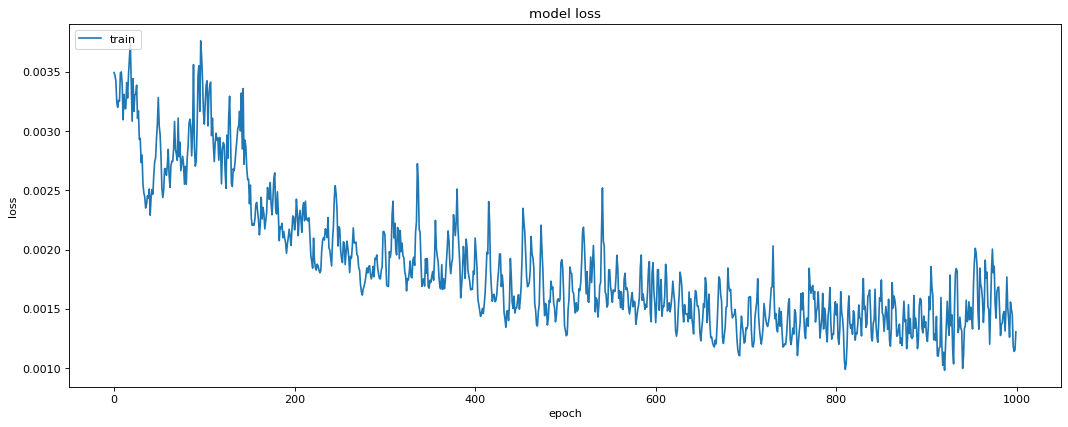

In [22]:
history = model.fit(
    X_train, Y_train,
    validation_data=(X_valid, Y_valid),
    epochs=maxEpochs,
    batch_size=miniBatchSize,
    validation_freq=1,
    shuffle=False,
    verbose=1,
    callbacks = callback
)

plt.figure(num=None, figsize=(16, 6), dpi=80, facecolor='w')
plt.plot(history.history['loss'])
#plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Testando a Rede

In [23]:
#X_test.shape
X_predict = model(X_test)
X_predict = np.transpose(X_predict[:,:,0])

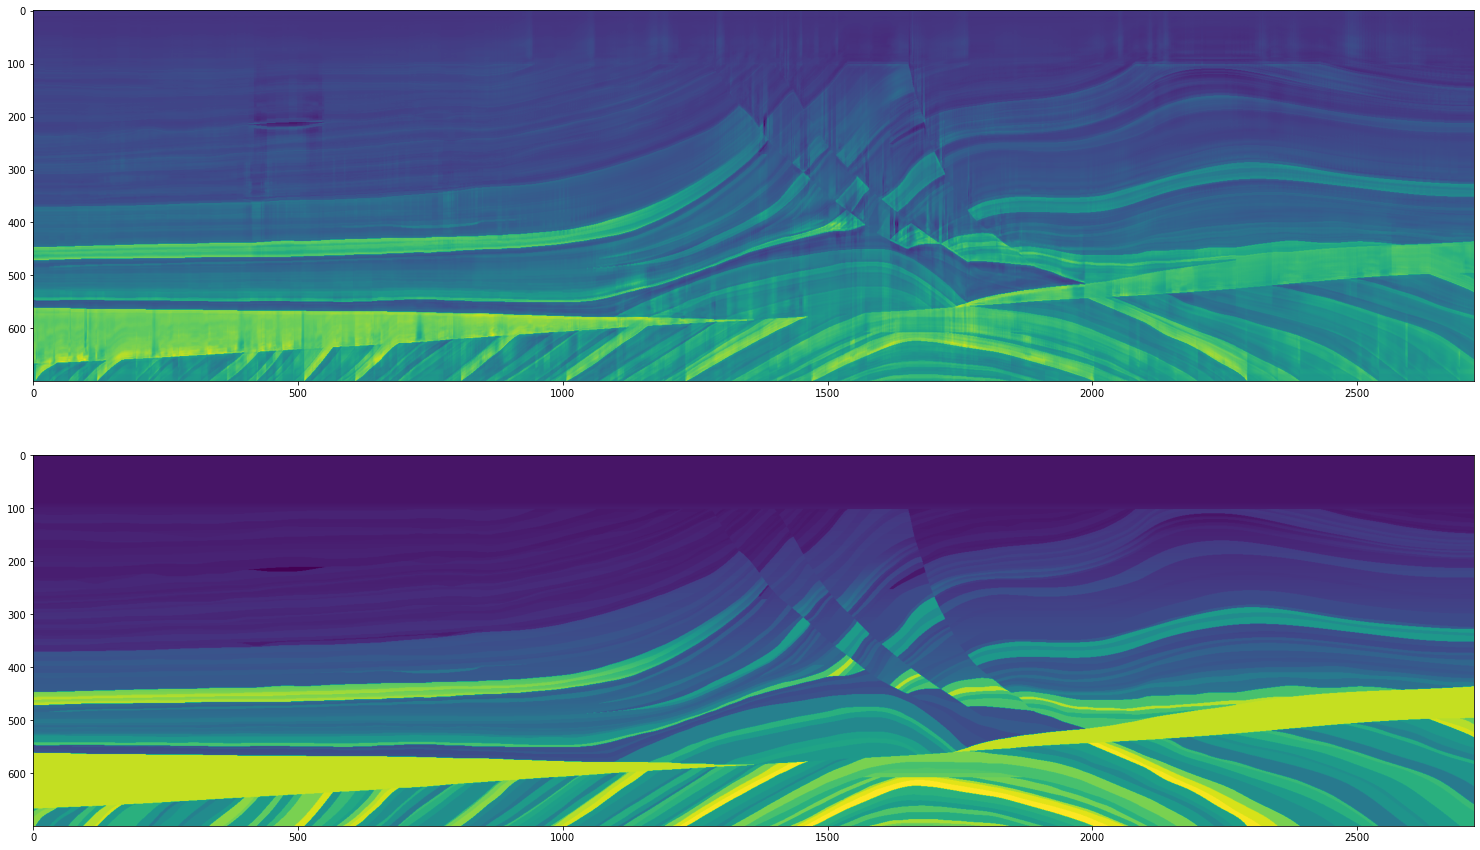

In [24]:
fig1, axes1 = plt.subplots(nrows=2, ncols=1, figsize=(50,15))
axes1[0].imshow(X_predict)
axes1[1].imshow(np.transpose(Y_test[:,:,0]))


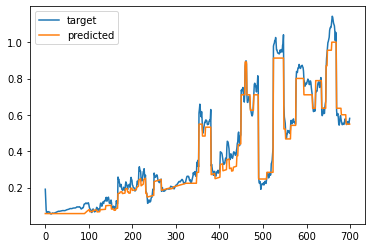

In [169]:
trace_id = np.random.randint(X_predict.shape[1])
plt.plot(X_predict[:,trace_id])
plt.plot(Y_test[trace_id,:,0])
plt.legend(('target','predicted'))